In [99]:
! pip install -q yfinance numpy pandas

In [100]:
import yfinance

In [101]:
tickers = ['AAPL', 'NVO']
timeframe = '5y' # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

In [111]:
data = yfinance.download(tickers, period=timeframe, rounding=True,)
for ticker in data['Close'].columns:
    stock = yfinance.Ticker(ticker)

    market_cap = stock.info.get('marketCap', None)
    total_debt = stock.info.get('totalDebt', None)
    cash = stock.info.get('totalCash', None)
    ebit = stock.financials.loc['Operating Income', :].iloc[0] if 'Operating Income' in stock.financials.index else None

    # EV/EBIT
    if market_cap and total_debt and cash and ebit:
        ev = market_cap + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
    else:
        ev_ebit = None

    # ROIC (assuming 21% tax rate)
    nopat = ebit * (1 - 0.21) if ebit else None
    invested_capital = (total_debt + market_cap - cash) if total_debt and cash else None
    roic = nopat / invested_capital if nopat and invested_capital else None

    # Write
    data['Daily Change (%)', ticker] = data['Close'][ticker].pct_change() * 100
    data['30-Day Change (%)', ticker] = (data['Close'][ticker] / data['Close'][ticker].shift(30) - 1) * 100
    data['1-Year Change (%)', ticker] = (data['Close'][ticker] / data['Close'][ticker].shift(252) - 1) * 100
    # Add Year-to-Date (YTD) Change for each ticker
    # Get the first trading day of the year for each ticker
    first_day_price = data['Close'][ticker].loc[data.index[data.index.year == data.index[-1].year].min()]
    data['Year-To-Date Change (%)', ticker] = (data['Close'][ticker] / first_day_price - 1) * 100
    data['Industry', ticker] = stock.info.get('industry', None)
    data['EV/EBIT', ticker] = ev_ebit
    data['ROIC (%)', ticker] = roic * 100

# Save to CSV
data.to_csv('data.csv', index=False)
data

[*********************100%***********************]  2 of 2 completed


Price        Close           High            Low           Open         \
Ticker        AAPL    NVO    AAPL    NVO    AAPL    NVO    AAPL    NVO   
Date                                                                     
2020-01-06   72.66  26.68   72.70  26.76   70.95  26.62   71.21  26.67   
2020-01-07   72.32  26.66   72.93  26.68   72.10  26.47   72.67  26.68   
2020-01-08   73.48  26.61   73.79  26.77   72.02  26.52   72.02  26.64   
2020-01-09   75.05  26.89   75.24  27.02   74.21  26.83   74.47  26.84   
2020-01-10   75.21  27.47   75.78  27.65   74.71  27.32   75.28  27.38   
...            ...    ...     ...    ...     ...    ...     ...    ...   
2024-12-27  255.59  87.37  258.70  88.77  253.06  87.02  257.83  87.73   
2024-12-30  252.20  85.73  253.50  87.01  250.75  85.66  252.23  86.97   
2024-12-31  250.42  86.02  253.28  86.05  249.43  85.00  252.44  85.42   
2025-01-02  243.85  87.52  249.10  88.51  241.82  87.19  248.93  87.91   
2025-01-03  243.36  87.65  244.18  88.19  241.89  87.34  243.36  87.49   

Price          Volume           ...              Industry    EV/EBIT  \
Ticker           AAPL      NVO  ...                  AAPL       AAPL   
Date                            ...                                    
2020-01-06  118387200  2495000  ...  Consumer Electronics  30.292081   
2020-01-07  108872000  2080600  ...  Consumer Electronics  30.292081   
2020-01-08  132079200  1826200  ...  Consumer Electronics  30.292081   
2020-01-09  170108400  1842000  ...  Consumer Electronics  30.292081   
2020-01-10  140644800  2943000  ...  Consumer Electronics  30.292081   
...               ...      ...  ...                   ...        ...   
2024-12-27   42355300  6066000  ...  Consumer Electronics  30.292081   
2024-12-30   35557500  6110000  ...  Consumer Electronics  30.292081   
2024-12-31   39480700  4202400  ...  Consumer Electronics  30.292081   
2025-01-02   55740700  4570300  ...  Consumer Electronics  30.292081   
2025-01-03   40202700  3763100  ...  Consumer Electronics  30.292081   

Price       ROIC (%) Daily Change (%) 30-Day Change (%) 1-Year Change (%)  \
Ticker          AAPL              NVO               NVO               NVO   
Date                                                                        
2020-01-06  2.607942              NaN               NaN               NaN   
2020-01-07  2.607942        -0.074963               NaN               NaN   
2020-01-08  2.607942        -0.187547               NaN               NaN   
2020-01-09  2.607942         1.052236               NaN               NaN   
2020-01-10  2.607942         2.156936               NaN               NaN   
...              ...              ...               ...               ...   
2024-12-27  2.607942        -0.319452        -18.277055        -14.802535   
2024-12-30  2.607942        -1.877075        -18.600456        -16.238398   
2024-12-31  2.607942         0.338271        -15.451150        -15.938630   
2025-01-02  2.607942         1.743781        -12.313395        -13.346535   
2025-01-03  2.607942         0.148537        -14.596122        -14.479461   

Price      Year-To-Date Change (%)                      Industry  EV/EBIT  \
Ticker                         NVO                           NVO      NVO   
Date                                                                        
2020-01-06              -69.515539  Drug Manufacturers - General  3.66402   
2020-01-07              -69.538391  Drug Manufacturers - General  3.66402   
2020-01-08              -69.595521  Drug Manufacturers - General  3.66402   
2020-01-09              -69.275594  Drug Manufacturers - General  3.66402   
2020-01-10              -68.612888  Drug Manufacturers - General  3.66402   
...                            ...                           ...      ...   
2024-12-27               -0.171389  Drug Manufacturers - General  3.66402   
2024-12-30               -2.045247  Drug Manufacturers - General  3.66402   
2024-12-31               -1.

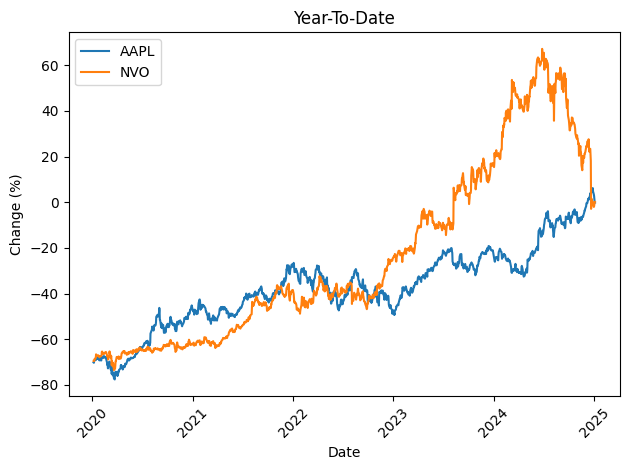

In [103]:
import matplotlib.pyplot as plt

for ticker in data['Year-To-Date Change (%)'].columns:
    plt.plot(data.index, data['Year-To-Date Change (%)'][ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Change (%)')
plt.title('Year-To-Date')
plt.legend()
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()